In [26]:
MODEL_PATH = 'architectures/'
DATASET_PATH = 'dataset/'
RANDOM_SEED = 42 # Set to `None` for the generator uses the current system time.

In [2]:
import sys
import os

# Check Python version
print(f"Python Version: `{sys.version}`")  # Detailed version info
print(f"Base Python location: `{sys.base_prefix}`")
print(f"Current Environment location: `{os.path.basename(sys.prefix)}`", end='\n\n')

import tensorflow as tf
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.config import list_physical_devices

print(f"Tensorflow version: `{tf.__version__}`")
print(f"CUDNN version: `{tf_build_info.build_info['cudnn_version']}`")
print(f"CUDA version: `{tf_build_info.build_info['cuda_version']}`")
print(f"Num GPUs Available: {len(list_physical_devices('GPU'))}")

Python Version: `3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]`
Base Python location: `C:\Users\LMT\AppData\Local\Programs\Python\Python310`
Current Environment location: `.venv_xai_fraud_detection`

Tensorflow version: `2.10.1`
CUDNN version: `64_8`
CUDA version: `64_112`
Num GPUs Available: 1


<!-- <a href="https://colab.research.google.com/github/siddharthapramanik771/CreditCardFraudDetectionML/blob/main/Credit_card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> -->

# Importing the necessary packages

In [3]:
# %pip install tensorflow==2.10.1 numpy==1.26.4 pandas scikit-learn imblearn matplotlib seaborn

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(RANDOM_SEED)

# Getting Relevant Data

In [5]:
# data = pd.read_csv(os.path.join(DATASET_PATH, 'fraudTest.csv'), index_col=0)
data = pd.read_csv(os.path.join(DATASET_PATH, 'fraudTrain.csv'), index_col=0)

# Credit Card Fraud Dataset Fields

| Field # | Field Name | Description |
|---------|------------|-------------|
| 1 | **trans_date_trans_time** | Date and time when transaction occurred |
| 2 | **cc_num** | Credit card number of customer |
| 3 | **merchant** | Name of merchant where transaction occurred |
| 4 | **category** | Category of merchant (e.g., retail, food, etc.) |
| 5 | **amt** | Amount of transaction |
| 6 | **first** | First name of credit card holder |
| 7 | **last** | Last name of credit card holder |
| 8 | **gender** | Gender of credit card holder |
| 9 | **street** | Street address of credit card holder |
| 10 | **city** | City of credit card holder |
| 11 | **state** | State of credit card holder |
| 12 | **zip** | ZIP code of credit card holder |
| 13 | **lat** | Latitude location of credit card holder |
| 14 | **long** | Longitude location of credit card holder |
| 15 | **city_pop** | Population of credit card holder's city |
| 16 | **job** | Occupation of credit card holder |
| 17 | **dob** | Date of birth of credit card holder |
| 18 | **trans_num** | Transaction number |
| 19 | **unix_time** | UNIX timestamp of transaction |
| 20 | **merch_lat** | Latitude location of merchant |
| 21 | **merch_long** | Longitude location of merchant |
| 22 | **is_fraud** | Target class indicating whether transaction is fraudulent (1) or legitimate (0) |

In [6]:
data['is_fraud'].value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

In [7]:
data.isnull().any().sum()

0

no mising data

# Feature Engineering

## Derive `age`, `age_group` feature from `dob`

In [8]:
data['dob'] = pd.to_datetime(data['dob'])
data['age'] = (pd.Timestamp.today() - data['dob']).dt.days // 365

In [9]:
# Define age bins (from 18 to 90 in 10-year increments)
age_bins = range(data['age'].min(), data['age'].max() + 10, 10)

data['age_group'] = pd.cut(data['age'], bins=age_bins, labels=[f"{i}-{i+9}" for i in age_bins[:-1]], right=False)

## Derive `dist` feature from `lat`,`long` and `merch_lat`, `merch_long`

In [10]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # Radius of earth in kilometers
    r = 6371

    return c * r

# Calculate distances and create new column
data['dist'] = haversine_distance(
    data['lat'],
    data['long'],
    data['merch_lat'],
    data['merch_long']
)

# Analysis

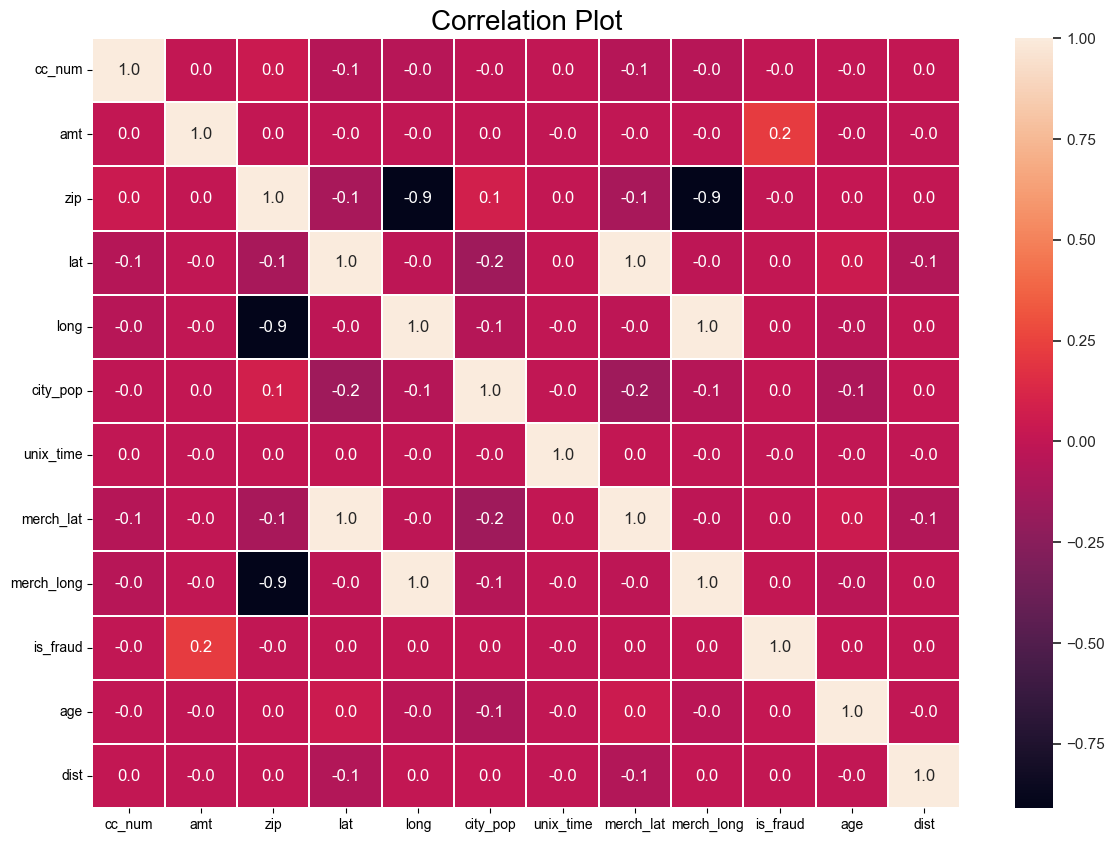

In [11]:
float_types_columns = []
for col in data:
    try:
        data[col].astype('float')
        float_types_columns.append(col)
    except:
        continue

plt.figure(figsize = (14,10))
plt.title('Correlation Plot', size = 20)
corr = data[float_types_columns].corr()
sns.set(rc={'figure.figsize':(13.7,8.27)})
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,fmt='.1f',annot=True)
plt.show()

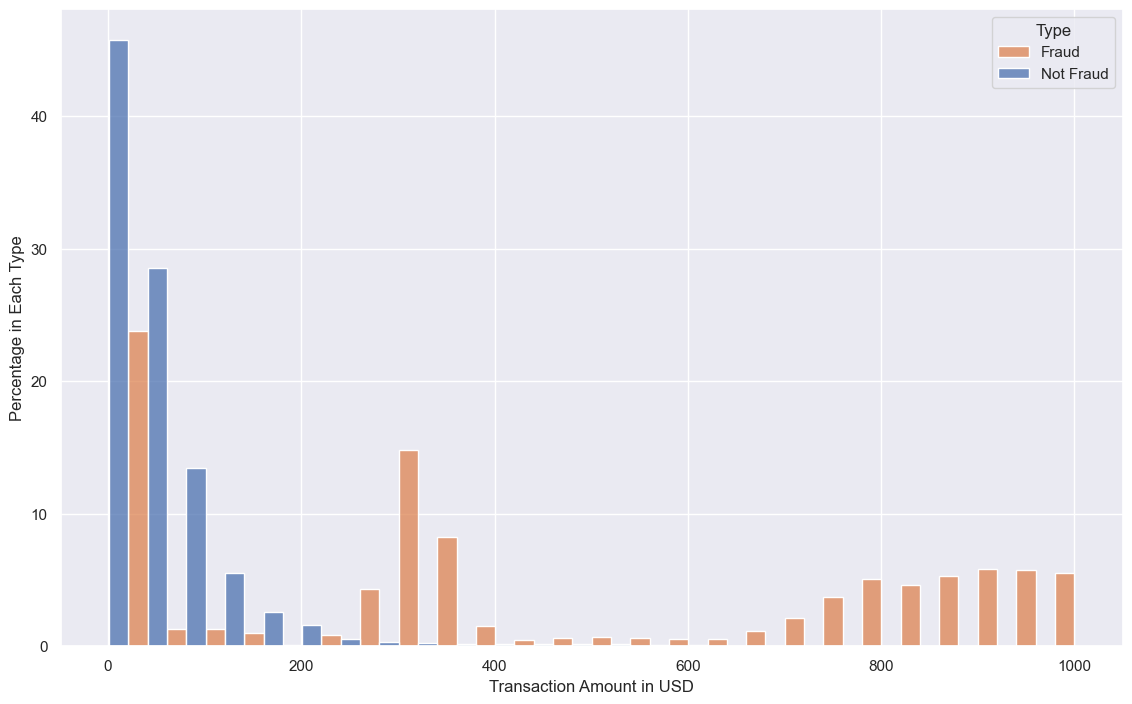

In [12]:
df = data
ax=sns.histplot(x='amt',data=df[df.amt<=1000],hue='is_fraud',stat='percent',multiple='dodge',common_norm=False,bins=25)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount in USD')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

In [13]:
# Get all the fraud data
fraud_data = data[data['is_fraud'] == 1]

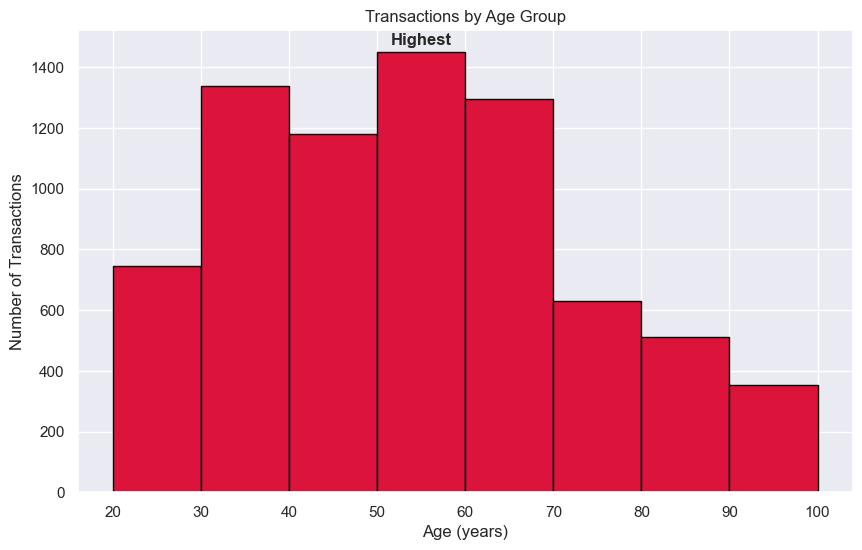

The age group with the most fraud transactions is 50 to 60 with 1450 fraud transactions.


In [14]:
plt.figure(figsize=(10, 6))
plt.xlabel('Age (years)')
plt.ylabel('Number of Transactions')
plt.title('Transactions by Age Group')
plt.xticks(age_bins)

# Create the histogram
counts, bins, patches = plt.hist(fraud_data['age'], bins=age_bins, edgecolor='black', color='crimson')

# Annotate the age group with highest transactions
plt.annotate(f'Highest', 
             xy=(bins[counts.argmax()] + 5, counts.max()),
             xytext=(0, 5),
             textcoords='offset points',
             ha='center',
             fontweight='bold',
)

plt.show()

print(f"The age group with the most fraud transactions is {age_bins[counts.argmax()]} to {age_bins[counts.argmax()+1]} with {int(counts.max())} fraud transactions.")

<Axes: xlabel='gender', ylabel='count'>

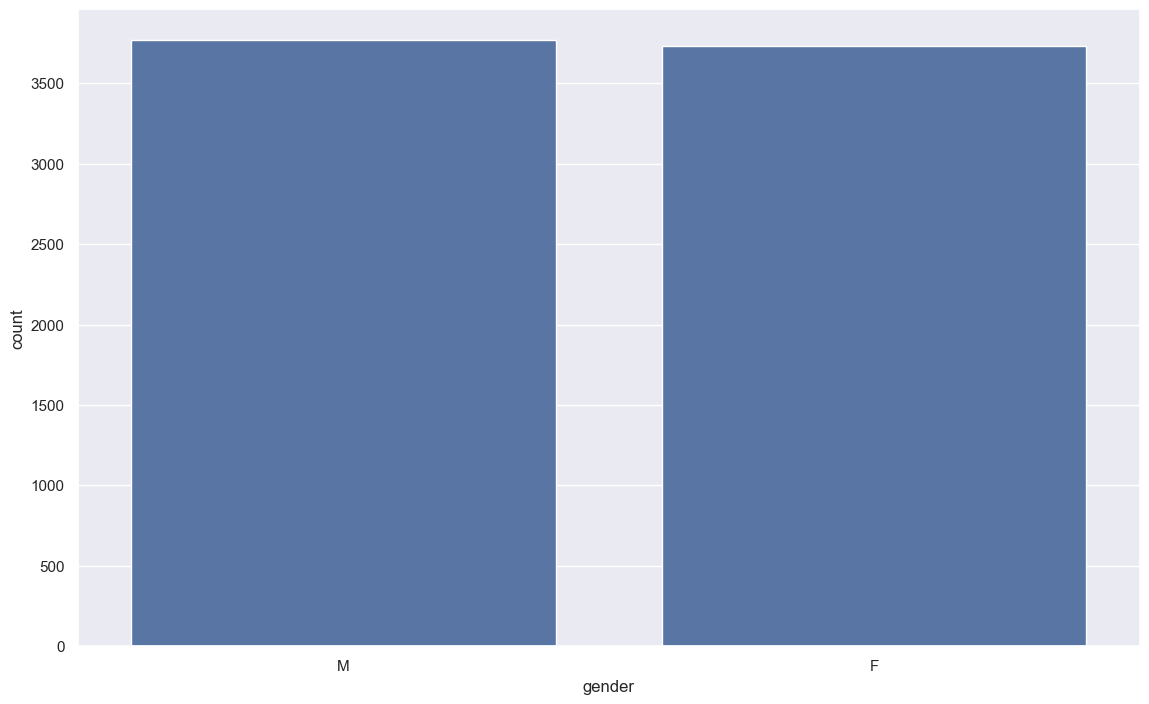

In [15]:
sns.countplot(x="gender", data=fraud_data)

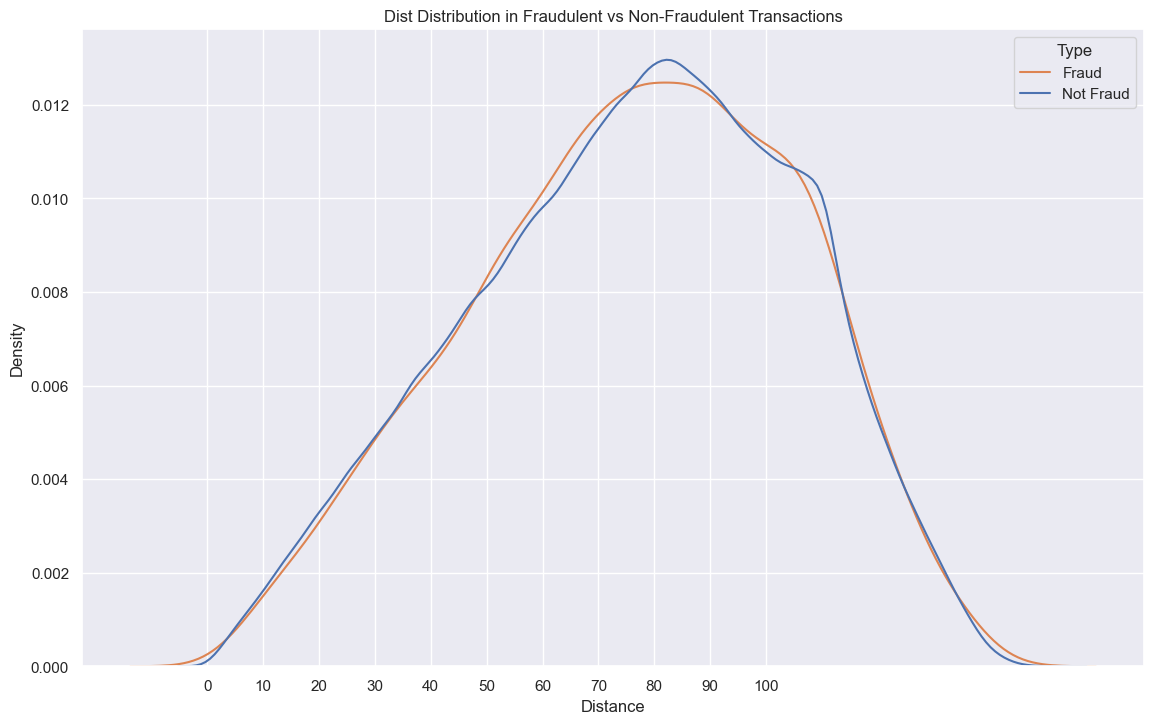

In [16]:
#Relation between distance vs fraud
import datetime as dt
import numpy as np
ax=sns.kdeplot(x='dist',data=df, hue='is_fraud', common_norm=False)
ax.set_xlabel('Distance')
ax.set_ylabel('Density')
plt.xticks(np.arange(0,110,10))
plt.title('Dist Distribution in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

In [17]:
# sns.countplot(x="state",data=df[df["is_fraud"]==1])

# Pre-processing

In [18]:
drop_cols = ["trans_date_trans_time", "cc_num","first","last","street","city", "state", "zip","job", 'dob',"trans_num"]
relevant_features = ['category', 'merchant', 'amt', 'gender', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'unix_time']

data = data.drop(columns=drop_cols, axis=1)

In [19]:
non_fraud = data[data['is_fraud'] == 0]
fraud = data[data['is_fraud'] == 1]

non_fraud = non_fraud.sample(len(fraud))

data = pd.concat([non_fraud, fraud])

data['is_fraud'].value_counts()

is_fraud
0    7506
1    7506
Name: count, dtype: int64

In [20]:
non_fraud

,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,age,age_group,dist
811778,"Zieme, Bode and Dooley",gas_transport,86.19,F,34.0287,-118.4924,92043,1354877706,33.287851,-118.740970,0,64,60-69,85.530738
1101718,Lind-Buckridge,entertainment,85.81,F,36.7154,-89.6287,1019,1364994606,36.539950,-89.857416,0,46,40-49,28.234251
800013,Hackett-Lueilwitz,grocery_pos,99.30,F,39.9636,-79.7853,184,1354604824,39.582872,-78.838550,0,79,70-79,91.317056
398945,Lynch-Wisozk,home,42.09,F,48.2777,-112.8456,743,1341081788,48.310513,-112.837535,0,52,50-59,3.697100
207455,Fisher-Schowalter,shopping_net,4.24,F,36.4715,-82.4834,87124,1334519869,37.329094,-82.070746,0,38,30-39,102.175759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477760,Rolfson-Kunde,personal_care,74.48,M,39.3900,-88.9597,1532,1343502475,40.291688,-89.521832,0,45,40-49,111.157376
1215574,Kihn-Schuster,food_dining,62.22,M,42.4069,-74.1528,277,1369348318,41.628510,-73.676442,0,53,50-59,95.078647
437865,Erdman-Ebert,personal_care,49.65,M,40.9918,-73.9800,4664,1342282369,40.763702,-73.699295,0,59,50-59,34.644964
1047310,Boyer PLC,shopping_net,3.62,F,30.9000,-94.7547,99,1362895173,30.484955,-93.916328,0,59,50-59,92.499114


In [21]:
label_encoders = {}
def data_processing(data,encoding=False):
  if encoding:
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns.to_list()
      
    # print(f'One Hot Encoding is applied for `{categorical_cols}`')
    # data = pd.get_dummies(data, prefix=categorical_cols, columns=categorical_cols, dtype='category')
      
    print(f'Ordinal-Encoding is applied for `{categorical_cols}`')
    global label_encoders
    for col in categorical_cols:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        data[col] = data[col].astype('category')
        label_encoders[col] = le  # Store for future reference
      
  y = data["is_fraud"]
  x = data.drop(["is_fraud"], axis=1)

  # Standardization
  scaler = StandardScaler()
  x = scaler.fit_transform(x)
  # X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

  # If the training data imbalanced we’ll address this using Synthetic Minority Oversampling Technique (SMOTE).
  # It is an oversampling technique that creates artificial minority class samples.
  # In our case, it creates synthetic fraud instances and so corrects the imbalance in our dataset.
  # y_train.value_counts()
  if y.value_counts()[0] != y.value_counts()[1]:
    print('SMOTE is applied')
    x, y = SMOTE().fit_resample(x, y)
  return x, y, data

In [22]:
X_train, y_train, processed_data = data_processing(data, encoding=True)
y_train.value_counts()

data_test = pd.read_csv(os.path.join(DATASET_PATH, 'fraudTest.csv'), index_col=0)
X_test, y_test, processed_data_test = data_processing(data_test, encoding=True)
y_test.value_counts()

Ordinal-Encoding is applied for `['merchant', 'category', 'gender', 'age_group']`
Ordinal-Encoding is applied for `['trans_date_trans_time', 'merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num']`
SMOTE is applied


is_fraud
0    553574
1    553574
Name: count, dtype: int64

In [23]:
features = processed_data.columns.drop('is_fraud')
features

Index(['merchant', 'category', 'amt', 'gender', 'lat', 'long', 'city_pop',
       'unix_time', 'merch_lat', 'merch_long', 'age', 'age_group', 'dist'],
      dtype='object')

In [24]:
X_train.shape

(15012, 13)

# Model Building

## using scikit-learn

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score,mean_absolute_error
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

model_impl = RandomForestClassifier()
# X_train = X_train.reshape(X_train.shape[0],1)
# X_test = X_test.reshape(X_test.shape[0],1)
model_impl.fit(X_train,y_train)
pred_train=model_impl.predict(X_train)
pred_test=model_impl.predict(X_test)

accuracy_train = accuracy_score(pred_train,y_train)
accuracy_test = accuracy_score(pred_test,y_test)
confusionMatrix = confusion_matrix(y_test,pred_test)
classificationReport = classification_report(y_test,pred_test)
mae = mean_absolute_error(y_train,pred_train)
# print("Model Implemented: ", 'Decision_tree')
print("Accuracy on Training Set: ", accuracy_train)
print('Accuracy on Validation Set: ', accuracy_test)
print('Mean absolute error: ',mae)
print('Confusion Matrix\n', confusionMatrix)
print('Classification Report\n', classificationReport)

(15012, 13) (15012,) (1107148, 21) (1107148,)


ValueError: X has 21 features, but RandomForestClassifier is expecting 13 features as input.

## using Tensorflow

In [ ]:
epochs = 50
model = Sequential()
model.add(Conv1D(64, 2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())

model.add(Conv1D(32, 2, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=1,callbacks = [callback])

In [ ]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

In [ ]:
plot_learningCurve(history,len(history.epoch))

In [ ]:
y_predict = model.predict(X_test)

In [ ]:
y_predict_binary = np.round(y_predict).astype(int).squeeze()
classificationReport = classification_report(y_test, y_predict_binary)
print(classificationReport)

In [ ]:
confusionMatrix = confusion_matrix(y_test, np.round(y_predict).astype(int))
confusionMatrix

In [ ]:
# Save the entire ANN model
model.save(os.path.join(MODEL_PATH, 'architecture_1'))

In [ ]:
# train_set = pd.DataFrame(np.concatenate([X_train.squeeze(), np.expand_dims(y_train.to_numpy(), axis=1)], axis=1), 
#              columns=list(features) + ['is_fraud'])

# train_set.to_csv(os.path.join(DATASET_PATH, 'architecture_1_train_set.csv'))

In [ ]:
# test_set = pd.DataFrame(np.concatenate([X_test.squeeze(), np.expand_dims(y_test.to_numpy(), axis=1)], axis=1), 
#              columns=list(features) + ['is_fraud'])

# test_set.to_csv(os.path.join(DATASET_PATH, 'architecture_1_test_set.csv'))

In [ ]:
# processed_data.to_csv(os.path.join(DATASET_PATH, 'architecture_1_dataset.csv'))